# TestCase4 v2 - Convergence FEM / PINNs+Corr

In [1]:
# sélection du cas test
testcase = 4
version = 1
param_num = 2

In [ ]:
assert testcase == 4 and version == 1

**Idée :** On se place ici dans le TestCase3.

On cherche à vérifier les convergences obtenues pour

- FEM standard
- le PINNs + Correction par addition

On choisira d'effectuer ces convergences en P1,P2 et P3

## Imports + Load

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import os
import dolfin as df

from scimba.equations.domain import SpaceTensor
from scimba.equations import domain
from modules.utils import create_tree

from modules.geometry import Donut
from modules.fenics_expressions import FExpr,UexExpr

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/home/u2/lecourtier/miniconda3/envs/test_phifem/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Using device: cpu


In [4]:
from modules.testcases.d2.test_4.test_4_v1 import Run_laplacian2D,Poisson_2D
from modules.solver_fem_4 import FEMSolver
from modules.problem import TestCase4
problem = TestCase4(v=version)

result_dir = "../../../results/2D/testcase"+str(testcase)+"/version"+str(version)
result_dir += "/cvg/"
create_tree(result_dir)

here
torch loaded; device is cpu


2
[[-0.5, 0.500001], [-0.5, 0.500001]]
[[-0.5, 0.500001], [-0.5, 0.500001]]
>> load network /home/u2/lecourtier/Article1/networks/test_fe4_v7.pth
network loaded
Error  tensor([0.0006])


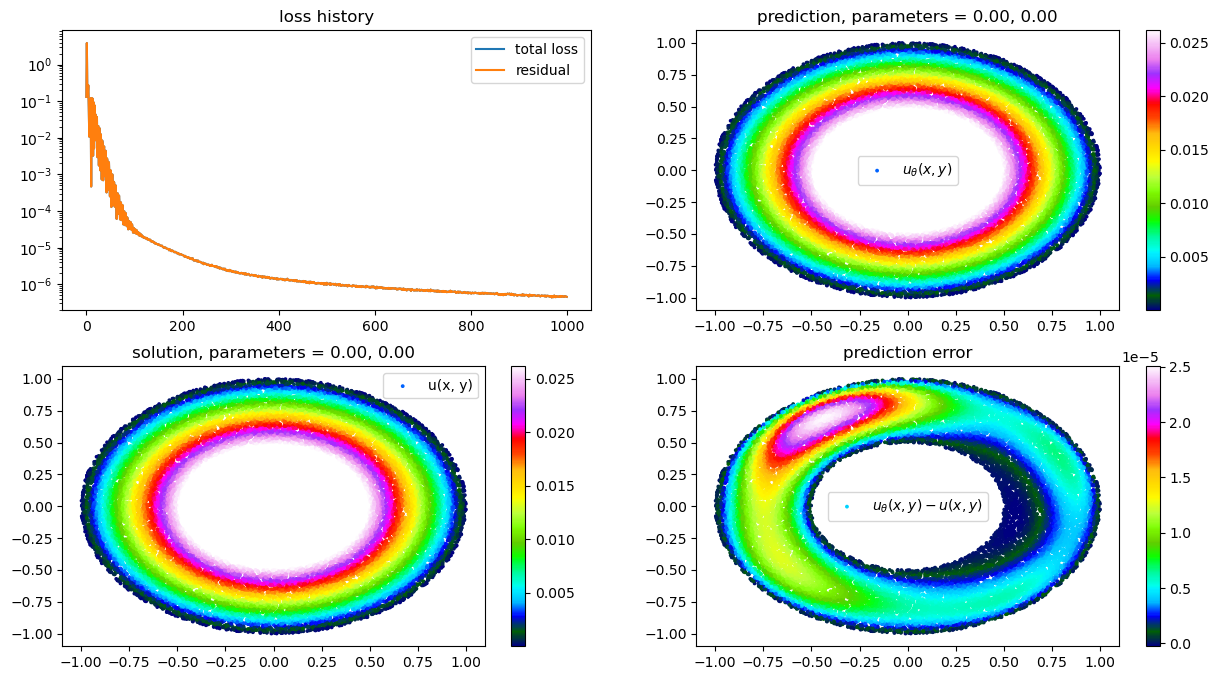

In [5]:
pde = Poisson_2D()
trainer,u_theta = Run_laplacian2D(pde)

In [6]:
def get_param(i):
    parameter_domain = problem.parameter_domain
    # pick 1 random parameter
    np.random.seed(0)
    for j in range(i):
        param = []
        for k in range(len(parameter_domain)):
            param.append(np.random.uniform(parameter_domain[k][0], parameter_domain[k][1]))
    param = np.round(param, 2)
    return param

param = get_param(param_num)
print(param)
params = [param]

[0.1  0.04]


## Solution de référence

In [7]:
from dolfin import *
prm = parameters["krylov_solver"]
prm["absolute_tolerance"] = 1e-13
prm["relative_tolerance"] = 1e-13

In [8]:
import mshr

def create_ref_domain(deg,nb_vert=500,H=None):    
    # check if pb_considered is instance of Square class
    if isinstance(problem.geometry, Donut):
        bigcenter = problem.geometry.bigcircle.center
        bigradius = problem.geometry.bigcircle.radius
        smallcenter = problem.geometry.hole.center
        smallradius = problem.geometry.hole.radius
        box = np.array(problem.geometry.box)

        bigcircle = mshr.Circle(df.Point(bigcenter[0],bigcenter[1]), bigradius)
        hole = mshr.Circle(df.Point(smallcenter[0],smallcenter[1]), smallradius)
        domain = bigcircle-hole    
    
        mesh_macro = RectangleMesh(Point(box[0,0], box[1,0]), Point(box[0,1], box[1,1]), nb_vert, nb_vert)
        h_macro = mesh_macro.hmax()
        print("h_macro = ",h_macro)
        
        if H is None:
            # H = int(nb_vert*3/5)
            H=700
        else:
            H = int(H)
        mesh_ref = mshr.generate_mesh(domain,H)
        h = mesh_ref.hmax()
        while h > h_macro:
            H += 1
            mesh_ref = mshr.generate_mesh(domain,H)            
            h = mesh_ref.hmax()
            print("h : ",h)
    else:
        raise ValueError("Geometry not implemented")
    
    V_ref = df.FunctionSpace(mesh_ref, "CG", deg)
    print(V_ref.tabulate_dof_coordinates().shape)
    dx_ref = df.Measure("dx", domain=mesh_ref)
    
    h_ref = mesh_ref.hmax()
    print("hmax = ",h_ref)

    return mesh_ref, V_ref, dx_ref, H
    
def get_uref(param,deg,nb_vert=500,H=None):
    mesh_ref, V_ref, dx_ref, H = create_ref_domain(deg,nb_vert,H)
    
    f_expr = FExpr(param, degree=10, domain=mesh_ref, pb_considered=problem)  
      
    g = Constant("0.0")
    
    if version == 2 or version == 3:
        def boundary_D(x,on_boundary):
            return on_boundary and x[0]**2+x[1]**2<0.75**2
        
        bc = DirichletBC(V_ref, g, boundary_D)
    elif version==4:
        bc = DirichletBC(V_ref, g, "on_boundary")
    
    u = df.TrialFunction(V_ref)
    v = df.TestFunction(V_ref)
    
    # Resolution of the variationnal problem

    a = df.inner(df.grad(u),df.grad(v)) * dx_ref
    l = f_expr * v * dx_ref

    sol = df.Function(V_ref)
    df.solve(a==l, sol, bcs=bc, solver_parameters={"linear_solver": "cg","preconditioner":"hypre_amg"})

    return sol,H


In [9]:
if testcase != 4 and testcase != 7:
    savedir = result_dir + "u_ref/"
    create_tree(savedir)

    nb_vert = 500
    deg_uref = 3

    filename = f"u_ref_{param_num}_P{deg_uref}_N{nb_vert}_H*.npy"
    pattern = os.path.join(savedir, filename)

    import glob
    matching_files = glob.glob(pattern)

    load_ref = True
    if not load_ref or not matching_files:
        print("Run")
        if matching_files:
            H = int(matching_files[0].split("_")[-1].split(".")[0][1:])
            u_ref,H = get_uref(param,deg=3,nb_vert=nb_vert,H=H)
        else:
            u_ref,H = get_uref(param,deg=3,nb_vert=nb_vert)
        vct_u_ref = u_ref.vector().get_local()
        filename = savedir + f"u_ref_{param_num}_P{deg_uref}_N{nb_vert}_H{H}.npy"
        np.save(filename, vct_u_ref)  
    else:
        print("Load")
        vct_u_ref = np.load(matching_files[0])
        H = int(matching_files[0].split("_")[-1].split(".")[0][1:])
        mesh_ref, V_ref, dx_ref, _ = create_ref_domain(deg=deg_uref,nb_vert=nb_vert,H=H)
        u_ref = df.Function(V_ref)
        u_ref.vector()[:] = vct_u_ref

In [10]:
if testcase != 4 and testcase != 7:
    plt.figure()
    plot(mesh_ref)
    plt.show()

In [11]:
if testcase != 4 and testcase != 7:
    plt.figure()
    c = plot(u_ref)
    plt.colorbar(c)
    plt.show()

## Convergence FEM

In [12]:
def read_csv(testcase,param_num,degree):
    csv_file = result_dir+f'FEM_case{testcase}_param{param_num}_degree{degree}.csv'
    df_FEM = pd.read_csv(csv_file)  
    tab_nb_vert_FEM = list(df_FEM['nb_vert'].values)
    tab_h_FEM = list(df_FEM['h'].values)
    tab_err_FEM = list(df_FEM['err'].values)
    
    return df_FEM,tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM

def run_FEM(degree,new_run=False):
    csv_file = result_dir+f'FEM_case{testcase}_param{param_num}_degree{degree}.csv'
    if not new_run and os.path.exists(csv_file):
        df_FEM,tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM = read_csv(testcase,param_num,degree)
        print(f"Read csv file {csv_file}")
    else:
        print("Run FEM")
        tab_nb_vert_FEM = [2**i for i in range(4,9)]
        tab_h_FEM = []
        tab_err_FEM = []

        for nb_vert in tab_nb_vert_FEM:
            solver = FEMSolver(nb_cell=nb_vert-1, params=params, problem=problem, degree=degree)
            tab_h_FEM.append(solver.h)
            if version == 4 or version == 7:
                _,norme_L2 = solver.fem(0)
            else:
                _,norme_L2 = solver.fem(0,u_ref)
            
            print(f"nb_vert={nb_vert}, norme_L2={norme_L2}")
            tab_err_FEM.append(norme_L2)
            
        df_FEM = pd.DataFrame({'nb_vert': tab_nb_vert_FEM, 'h': tab_h_FEM, 'err': tab_err_FEM})
        df_FEM.to_csv(csv_file, index=False)
            
    return df_FEM,tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM

In [13]:
degree = 1
df_FEM, tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM = run_FEM(degree)

Read csv file ../../../results/2D/testcase4/version7/cvg/FEM_case4_param2_degree1.csv


degree=1
Read csv file ../../../results/2D/testcase4/version7/cvg/FEM_case4_param2_degree1.csv
degree=2
Read csv file ../../../results/2D/testcase4/version7/cvg/FEM_case4_param2_degree2.csv
degree=3
Read csv file ../../../results/2D/testcase4/version7/cvg/FEM_case4_param2_degree3.csv


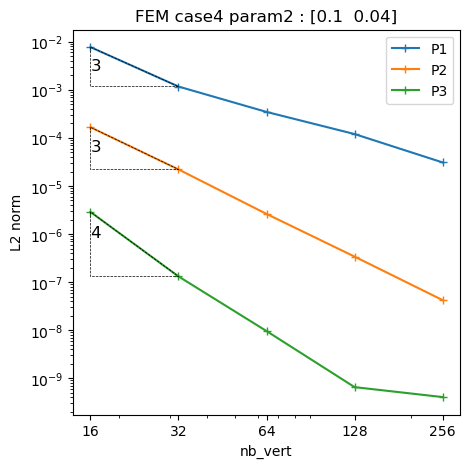

In [14]:
plt.figure(figsize=(5, 5))

# plot FEM error (L2 norm) as a function of h
for d in [1, 2, 3]:
    print(f"degree={d}")
    
    df_FEM, tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM = run_FEM(d)
    plt.loglog(df_FEM['nb_vert'], df_FEM['err'], "+-", label='P'+str(d))
    
    # add slope with a triangle
    start = [tab_nb_vert_FEM[1],tab_err_FEM[1]]
    end = [tab_nb_vert_FEM[0],tab_err_FEM[0]]
    third = [end[0],start[1]]
    
    tri_x = [end[0], third[0], start[0], end[0]]
    tri_y = [end[1], third[1], start[1], end[1]]
    plt.plot(tri_x, tri_y, "k--", linewidth=0.5)
    
    slope = (np.log(start[1])-np.log(end[1]))/(np.log(start[0])-np.log(end[0]))
    slope = abs(int(slope.round(0)))

    vert_mid = [(end[0]+third[0])/2., (end[1]+third[1])/2.]
    plt.text(vert_mid[0]+1e-2 , vert_mid[1], str(slope), fontsize=12, ha='left', va='top')
    
plt.xticks(df_FEM['nb_vert'], df_FEM['nb_vert'].round(3).astype(str))
plt.xlabel('nb_vert')
plt.ylabel('L2 norm')
plt.title(f'FEM case{testcase} param{param_num} : {param}')
plt.legend()
plt.savefig(result_dir+f'FEM_case{testcase}_param{param_num}.png')

In [15]:
dict = {}
for d in [1, 2, 3]:
    print(f"degree={d}")
    _, tab_nb_vert_FEM, _, tab_err_FEM = run_FEM(d)
    if d == 1:
        dict['N'] = tab_nb_vert_FEM
    dict[f'P{d}'] = tab_err_FEM
    
df_deg = pd.DataFrame(dict)

csv_file = result_dir+f'FEM_case{testcase}_param{param_num}.csv'
df_deg.to_csv(csv_file, index=False)

degree=1
Read csv file ../../../results/2D/testcase4/version7/cvg/FEM_case4_param2_degree1.csv
degree=2
Read csv file ../../../results/2D/testcase4/version7/cvg/FEM_case4_param2_degree2.csv
degree=3
Read csv file ../../../results/2D/testcase4/version7/cvg/FEM_case4_param2_degree3.csv


## Convergence PINNs+Corr

In [16]:
def get_test_sample(i,V_test,trainer):
    # get coordinates of the dof
    XXYY = V_test.tabulate_dof_coordinates()
    X_test = torch.tensor(XXYY,requires_grad=True)
    X_test = SpaceTensor(X_test,torch.zeros_like(X_test,dtype=int))

    # get parameters
    nb_params = len(trainer.pde.parameter_domain)
    shape = (XXYY.shape[0],nb_params)
    ones = torch.ones(shape)
    mu_test = (torch.Tensor(params[i]).to(device) * ones).to(device)

    return X_test,mu_test

def FEniCSpred(i,V_test,trainer):
    X_test,mu_test = get_test_sample(i,V_test,trainer)
    pred = u_theta.setup_w_dict(X_test, mu_test)
    phi_tild = pred["w"][:,0].cpu().detach().numpy()
    
    u_PINNs = df.Function(V_test)
    u_PINNs.vector()[:] = phi_tild.copy()

    return u_PINNs

In [17]:
degree_PINNs = 10

def read_csv_Corr(testcase,param_num,degree):
    df_Corr = pd.read_csv(result_dir+f'Corr_case{testcase}_param{param_num}_degree{degree}.csv')
    tab_nb_vert_Corr = list(df_Corr['nb_vert'].values)
    tab_h_Corr = list(df_Corr['h'].values)
    tab_err_Corr = list(df_Corr['err'].values)
    
    return df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr

def run_Corr(degree,new_run=False,plot_all = False):
    csv_file = result_dir+f'Corr_case{testcase}_param{param_num}_degree{degree}.csv'
    if not new_run and os.path.exists(csv_file):
        df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr = read_csv_Corr(testcase,param_num,degree)
        print(f"Read csv file {csv_file}")
    else:
        tab_nb_vert_Corr = [2**i for i in range(4,9)]
        tab_h_Corr = []
        tab_err_Corr = []

        for nb_vert in tab_nb_vert_Corr:
            solver = FEMSolver(nb_cell=nb_vert-1, params=params, problem=problem, degree=degree, high_degree=degree_PINNs)
            
            tab_h_Corr.append(solver.h)
            
            # Compute PINNs solution
            V_test = df.FunctionSpace(solver.mesh,"CG",degree_PINNs)
            u_PINNs = FEniCSpred(0,V_test,trainer)
            u_PINNs_inter = FEniCSpred(0,solver.V,trainer)
            
            # Compute PINNs Error
            u_ref = UexExpr(param, degree=10, domain=solver.mesh, pb_considered=problem)
            
            uref_Vex = df.interpolate(u_ref,solver.V_ex)
            sol_Vex = df.interpolate(u_PINNs,solver.V_ex)
            norme_L2_PINNs = (df.assemble((((uref_Vex - sol_Vex)) ** 2) * solver.dx) ** (0.5)) / (df.assemble((((uref_Vex)) ** 2) * solver.dx) ** (0.5))

            print(f"# norme_L2_PINNs={norme_L2_PINNs}")

            sol,C_tild,norme_L2 = solver.corr_add(0,u_PINNs,u_PINNs_inter)
            print(f"nb_vert={nb_vert}, norme_L2={norme_L2}")
            tab_err_Corr.append(norme_L2)
            
            #### PLOTT
            if plot_all and nb_vert in [16,32,64]:
                colormap = "jet"

                C_ex = df.Function(solver.V)
                u_ref_inter = df.interpolate(u_ref,solver.V)
                C_ex.vector()[:] = u_ref_inter.vector()[:] - u_PINNs_inter.vector()[:]

                plt.figure(figsize=(15,10))

                plt.subplot(2,3,1)
                c = df.plot(C_ex,cmap=colormap)
                plt.colorbar(c)
                plt.title("C_ex")

                plt.subplot(2,3,2)
                c = df.plot(C_tild,cmap=colormap)
                plt.colorbar(c)
                plt.title("C_tild")

                plt.subplot(2,3,3)
                error = df.Function(solver.V)
                error.vector()[:] = C_ex.vector()[:] - C_tild.vector()[:]
                c = df.plot(error,cmap=colormap)
                plt.colorbar(c)
                plt.title("C_ex-C_tild")
                
                plt.subplot(2,3,4)
                c = df.plot(u_ref_inter,cmap=colormap)
                plt.colorbar(c)
                plt.title("u_ex")
                
                plt.subplot(2,3,5)
                # sol_inter = df.project(sol,solver.V)
                sol_inter = df.Function(solver.V)
                sol_inter.vector()[:] = u_PINNs_inter.vector()[:] + C_tild.vector()[:]
                c = df.plot(sol_inter,cmap=colormap)
                plt.colorbar(c)
                plt.title("sol")
                
                plt.subplot(2,3,6)
                error = df.Function(solver.V)
                error.vector()[:] = u_ref_inter.vector()[:] - sol_inter.vector()[:]
                c = df.plot(error,cmap=colormap)
                plt.colorbar(c)
                plt.title(f"u_ex-sol\nL2 norm : {norme_L2:.2e}")    
                
                plt.suptitle(f"nb_vert={nb_vert}")
                
                plt.savefig(result_dir+f'plotcorr_case{testcase}_v{version}_N{nb_vert}_degree{degree}.png')

        df_Corr = pd.DataFrame({'nb_vert': tab_nb_vert_Corr, 'h': tab_h_Corr, 'err': tab_err_Corr})
        df_Corr.to_csv(csv_file, index=False)
            
    return df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr

In [18]:
degree = 1
df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr = run_Corr(degree)

hmax =  0.16663035129479017
# norme_L2_PINNs=0.00047299826752821814
Calling FFC just-in-time (JIT) compiler, this may take some time.
nb_vert=16, norme_L2=4.5721806422243135e-05
hmax =  0.08691933730437637
# norme_L2_PINNs=0.0004766733611899058
nb_vert=32, norme_L2=1.239616789589932e-05
hmax =  0.04347038548979546
# norme_L2_PINNs=0.0004777491322199472
nb_vert=64, norme_L2=3.1907300940770333e-06
hmax =  0.02197797091453632
# norme_L2_PINNs=0.0004780176377069036
nb_vert=128, norme_L2=7.853609046279816e-07
hmax =  0.010988924822874708
# norme_L2_PINNs=0.0004780860786630866
nb_vert=256, norme_L2=1.940215439387298e-07


degree=1
Read csv file ../../../results/2D/testcase4/version7/cvg/Corr_case4_param2_degree1.csv
degree=2
hmax =  0.16663035129479017
# norme_L2_PINNs=0.00047299826752821814
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
nb_vert=16, norme_L2=2.15659066303701e-06
hmax =  0.08691933730437637
# norme_L2_PINNs=0.0004766733611899058
nb_vert=32, norme_L2=3.001010210167438e-07
hmax =  0.04347038548979546
# norme_L2_PINNs=0.0004777491322199472
nb_vert=64, norme_L2=3.6085384105200385e-08
hmax =  0.02197797091453632
# norme_L2_PINNs=0.0004780176377069036
nb_vert=128, norme_L2=4.542000987452358e-09
hmax =  0.010988924822874708
# norme_L2_PINNs=0.0004780860786630866
nb_vert=256, norme_L2=5.662935168678359e-10
degree=3
hmax =  0.16663035129479017
# norme_L2_PINNs=0.00047299826752821814
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


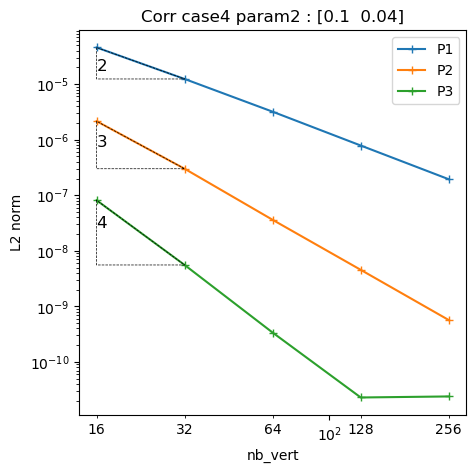

In [19]:
plt.figure(figsize=(5, 5))

# plot Corr error (L2 norm) as a function of h
for d in [1, 2, 3]:
    print(f"degree={d}")
    df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr = run_Corr(d)
    plt.loglog(df_Corr['nb_vert'], df_Corr['err'], "+-", label='P'+str(d))
    
    # add slope with a triangle
    start = [tab_nb_vert_Corr[1],tab_err_Corr[1]]
    end = [tab_nb_vert_Corr[0],tab_err_Corr[0]]
    third = [end[0],start[1]]
    
    tri_x = [end[0], third[0], start[0], end[0]]
    tri_y = [end[1], third[1], start[1], end[1]]
    plt.plot(tri_x, tri_y, "k--", linewidth=0.5)
    
    slope = (np.log(start[1])-np.log(end[1]))/(np.log(start[0])-np.log(end[0]))
    slope = abs(int(slope.round(0)))

    vert_mid = [(end[0]+third[0])/2., (end[1]+third[1])/2.]
    plt.text(vert_mid[0]+1e-2 , vert_mid[1], str(slope), fontsize=12, ha='left', va='top')

plt.xticks(df_Corr['nb_vert'], df_Corr['nb_vert'].round(3).astype(str), minor=True)
plt.xlabel("nb_vert")
plt.ylabel('L2 norm')
plt.legend()
plt.title(f'Corr case{testcase} param{param_num} : {param}')
plt.savefig(result_dir+f'Corr_case{testcase}_param{param_num}.png')

In [20]:
dict = {}
for d in [1, 2, 3]:
    print(f"degree={d}")
    _, tab_nb_vert_Corr, _, tab_err_Corr = run_Corr(d)
    if d == 1:
        dict['N'] = tab_nb_vert_Corr
    dict[f'P{d}'] = tab_err_Corr
    
df_deg_Corr = pd.DataFrame(dict)

csv_file = result_dir+f'Corr_case{testcase}_param{param_num}.csv'
df_deg_Corr.to_csv(csv_file, index=False)

degree=1
Read csv file ../../../results/2D/testcase4/version7/cvg/Corr_case4_param2_degree1.csv
degree=2
Read csv file ../../../results/2D/testcase4/version7/cvg/Corr_case4_param2_degree2.csv
degree=3
Read csv file ../../../results/2D/testcase4/version7/cvg/Corr_case4_param2_degree3.csv


## Plots

degree=1
Read csv file ../../../results/2D/testcase4/version7/cvg/FEM_case4_param2_degree1.csv
degree=2
Read csv file ../../../results/2D/testcase4/version7/cvg/FEM_case4_param2_degree2.csv
degree=3
Read csv file ../../../results/2D/testcase4/version7/cvg/FEM_case4_param2_degree3.csv
degree=1
Read csv file ../../../results/2D/testcase4/version7/cvg/Corr_case4_param2_degree1.csv
degree=2
Read csv file ../../../results/2D/testcase4/version7/cvg/Corr_case4_param2_degree2.csv
degree=3
Read csv file ../../../results/2D/testcase4/version7/cvg/Corr_case4_param2_degree3.csv


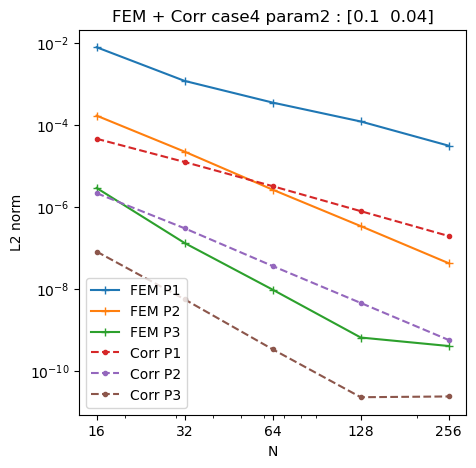

In [21]:
plt.figure(figsize=(5, 5))

# plot FEM error (L2 norm) as a function of h
for d in [1, 2, 3]:
    print(f"degree={d}")
    df_FEM, tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM = run_FEM(d)
    plt.loglog(df_FEM['nb_vert'], df_FEM['err'], "+-", label='FEM P'+str(d))

# plot Corr error (L2 norm) as a function of h
for d in [1, 2, 3]:
    print(f"degree={d}")
    df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr = run_Corr(d)
    plt.loglog(df_Corr['nb_vert'], df_Corr['err'], ".--", label='Corr P'+str(d))

plt.xticks(df_Corr['nb_vert'], df_Corr['nb_vert'].round(3).astype(str), minor=False)
plt.xlabel("N")
plt.ylabel('L2 norm')
plt.legend()
plt.title(f'FEM + Corr case{testcase} param{param_num} : {param}')
plt.savefig(result_dir+f'FEM-Corr_case{testcase}_param{param_num}.png')